****
# **COMPARATIVA: DATOS ORIGINALES VS. SIMULADOS**
****
**Autor:** Sergio Bolívar Gómez.

**Fecha:** 14 de abril de 2023.

## **IMPORTACIÓN DE LIBRERÍAS**

Importamos librerías más generales que vamos a utilizar en este notebook:

In [142]:
import os # para interacturar con el sistema
import pandas as pd # para manejar DataFrames
import numpy as np # para manejar arrays y hacer operaciones sobre ellos
import matplotlib.pyplot as plt # para hacer gráficas
import seaborn as sns # para hacer gráficas mejores
import math # para hacer algunas operaciones
import glob # para aglutinar archivos
import copy # para hacer copias de objetos de Python
import pickle # para guardar diccionario de Python en ficheros
import random # para hacer elecciones aleatorias y establecer semillas

from scipy.interpolate import interp1d # para remuestrear señal
from datetime import datetime # para formatear fechas

## **IMPORTACIÓN DE LOS DATOS**

En primer lugar, construimos una lista que contiene los identificadores de las palanquillas simuladas.

In [143]:
output_files_path = "/home/bolivars/Escritorio/data/preprocessed/files-to-ml/outputs" # CHANGEME: esto es un path a una carpeta con los inputs/outputs de las palanquillas simuladas

simul_billets = [] # esta lista contendrá los identificadores de las palanquillas que se han simulado

for filename in os.listdir(output_files_path): # recorremos los archivos del path anterior
    if filename.startswith("resultados_caso_estudio_palanquilla_") and filename.endswith(".csv"):
        number = filename.split("_")[-1].split(".")[0] # extraemos el identificador de la palanquilla
        simul_billets.append(number) # añadimos el identificador de la palanquilla a la lista

simul_billets.sort() # ordenamos la lista

Una vez tenemos la lista con las palanquillas, podemos cargar información adicional (como la longitud, el material, el hilo, el diámetro...).

In [144]:
info_palanquillas_db ={}

long_path = "/home/bolivars/Escritorio/data/raw/additional-info"  # CHANGEME: ruta que lleve a la información adicional de las palanquillas

file_pattern = os.path.join(long_path, "long_*.csv") # patrón útil para localizar los ficheros con información sobre las palanquillas
long_files = glob.glob(file_pattern) # lista con todos los ficheros proporcionados por GSW

data_to_store = ["long_punta", "long_cola", "diametro", "hilo", "material", "calidad"] # variables que representan la información que queremos almacenar

for long_data_file in long_files: # recorremos los ficheros proporcionados por GSW

    original_data = pd.read_csv(long_data_file, sep = ',', decimal = ".", # leemos los datos originales desde el CSV
                                usecols=lambda col: col != "Unnamed: 0"
                                ) # eliminamos la variable unnamed (basura)
    
    data_grouped_by_bulto = original_data.groupby('bulto') # agrupamos los datos según el bulto (identificador de la palanquilla)

    for name, group in data_grouped_by_bulto:

        palanquilla_info = {k: pd.DataFrame(group)[k].values[0] for k in data_to_store} # diccionario que contendrá la información especificada en la lista 'info_to_store'  

        info_palanquillas_db[name] = palanquilla_info # la key es el bulto de la palanquilla (identificador); el value el diccionario con toda la información

In [145]:
print(f"NÚMERO DE PALANQUILLAS SIMULADAS: {len(simul_billets)}")

NÚMERO DE PALANQUILLAS SIMULADAS: 148


Construimos la función que se encarga de hacer la comparativa...

In [146]:
# Para usar la fuente de LaTex en los plots
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']

In [147]:
def compare_simulations_vs_original_data(billet=6211346):

    """Función que compara los perfiles de temperatura simulados y originales de una palanquilla.

    ARGUMENTOS:
        billet (int): identificador de la palanquilla que se quiere analizar.
    """

    ###################################
    # CARGADO Y PREPROCESADO DE DATOS #
    ###################################

    original_data_path = f"/home/bolivars/Escritorio/data/preprocessed/files-to-ml/inputs/caso_estudio_palanquilla_{billet}.csv"
    simulations_path = f"/home/bolivars/Escritorio/data/preprocessed/files-to-ml/outputs/resultados_caso_estudio_palanquilla_{billet}.csv"

    outlet_temp_original = pd.read_csv(original_data_path, sep = ',', decimal = ".", usecols=["posicion", "outlet_temp"]).drop_duplicates(subset=['posicion'], keep='first')
    outlet_temp_simul = pd.read_csv(simulations_path, sep = ',', decimal = ".") # leemos los outputs de la simulación desde el CSV

    # DATOS ORIGINALES
    threshold_temp = 950 # umbral a partir del cual considero la primera medida de salida
    max_billet_length_simul = outlet_temp_simul["posicion"].iloc[-1] # máxima posición de la palanquilla simulada
    first_position = outlet_temp_original.loc[outlet_temp_original["outlet_temp"] > threshold_temp, "posicion"].iloc[0] # primera medida que supera umbra de temperatura, primera salida

    outlet_temp_original = outlet_temp_original.query('posicion >= @first_position')
    outlet_temp_original.loc[:, "posicion"] = outlet_temp_original["posicion"] - outlet_temp_original["posicion"].iloc[0]
    outlet_temp_original = outlet_temp_original.query('posicion <= @max_billet_length_simul') # elimino las medidas que se salen de la simulación
    outlet_temp_original = outlet_temp_original.reset_index(drop=True)

    # DATOS ORIGINALES SMOOTHED (TENDENCIA, USANDO MEDIAS MÓVILES EXPONENCIALES)
    outlet_temp_smoothed = outlet_temp_original.copy()
    outlet_temp_smoothed = outlet_temp_smoothed.ewm(span = 20, adjust=True).mean()

    # DATOS SIMULADOS CON ANSYS (interpolamos para tener la misma granularidad que los datos originales)
    new_size = outlet_temp_original.shape[0] 
    pos_temp = outlet_temp_simul[["posicion", "temperatura"]].values 
    new_indices = np.linspace(0, len(pos_temp)-1, new_size) 
    resampled_pos_temp = np.zeros((new_size, 2))

    resampled_pos_temp[:, 0] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 0]) # interpolamos posición
    resampled_pos_temp[:, 1] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 1]) # interpolamos temperatura

    outlet_temp_simul = pd.DataFrame({'posicion': resampled_pos_temp[:,0], 'outlet_temp': resampled_pos_temp[:,1]})

    # AJUSTE DIMENSIONAL PARA PODER COMPARAR PUNTO A PUNTO
    pos_original = np.array(outlet_temp_original["posicion"])
    temp_original = np.array(outlet_temp_original["outlet_temp"])

    pos_smoothed = np.array(outlet_temp_smoothed["posicion"])
    temp_smoothed = np.array(outlet_temp_smoothed["outlet_temp"])

    pos_simul = np.array(outlet_temp_simul["posicion"])
    temp_simul = np.array(outlet_temp_simul["outlet_temp"])

    pos_min = 0 # inicio de la palaquilla
    pos_max = min(max(pos_original), max(pos_smoothed), max(pos_simul)) # posición máxima alcanzable: mínimo entre los máximos alcanzados
    # pos_max = 19.5 # posición máxima alcanzable: lo máximo simulado

    dx = pos_simul[1] - pos_simul[0]
    pos_new = np.arange(pos_min, pos_max, dx) # nuevo eje de posiciones

    # Interpolo los valores de la temperatura de salida original al nuevo eje de posiciones
    f1 = interp1d(pos_original, temp_original, kind='slinear', fill_value='extrapolate')
    temp_original = f1(pos_new)

    # Interpolo los valores de la temperatura de salida original "suavizadas" al nuevo eje de posiciones
    f2 = interp1d(pos_smoothed, temp_smoothed, kind='slinear', fill_value='extrapolate')
    temp_smoothed = f2(pos_new)

    # Interpolo los valores de la temperatura de salida simulada al nuevo eje de posiciones
    f3 = interp1d(pos_simul, temp_simul, kind='slinear', fill_value='extrapolate')
    temp_simul = f3(pos_new)

    ###################################
    #       CÁLCULO DE MÉTRICAS       #
    ###################################
    mse_original_simul = np.mean((temp_original - temp_simul) ** 2)
    rmse_original_simul = np.sqrt(np.mean((temp_original - temp_simul) ** 2))
    corr_original_simul = np.corrcoef(temp_original, temp_simul)[0,1]

    mse_trend_simul = np.mean((temp_smoothed - temp_simul) ** 2)
    rmse_trend_simul = np.sqrt(np.mean((temp_smoothed - temp_simul) ** 2))
    corr_trend_simul = np.corrcoef(temp_smoothed, temp_simul)[0,1]

    metrics = {'PALANQUILLA': billet,
               'CALIDAD': [info_palanquillas_db[billet]["calidad"]],
               'RMSE (Simul.vs.Original)': [rmse_original_simul], 
               'CORRELACION (Simul.vs.Original)': [corr_original_simul],
               'RMSE (Simul.vs.Tendencia)': [rmse_trend_simul], 
               'CORRELACION (Simul.vs.Tendencia)': [corr_trend_simul]}

    dist_original_simul = np.abs(temp_original - temp_simul)
    dist_trend_simul = np.abs(temp_smoothed - temp_simul)
        
    ###################################
    #      REPRESENTACIÓN GRÁFICA     #
    ###################################

    figures_path ="/home/bolivars/Escritorio/code/2-finite-element-model/comparative-plots" # CHANGEME: cambiar al path en el que se quieran almacenar las gráficas

    # GRÁFICA COMPARATIVA
    plt.figure(figsize=(10,6)) # tamaño de la figura

    plt.plot(pos_new, temp_original, label=r'\textsc{Measured Temperature}', color = "black") # representamos temperatura original monitorizada a la salida
    plt.plot(pos_new, temp_smoothed, '+-', label=r'\textsc{Measured Temperature (TREND)}', color = "green") 
    plt.plot(pos_new, temp_simul, '--', label=r'\textsc{FE Simulated Temperature}', color = "red") # representamos temperatura simulada a la salida
    
    # Metadatos
    plt.title(fr'\textsc{{BILLET {billet}}}', fontsize = 16) 
    plt.xlabel(r'\textsc{Position} (m)')
    plt.ylabel(r'\textsc{Temperature} (ºC)') 
    plt.gcf().text(0.68, -0.085, fr'\textsc{{FE Simulation vs. Trend: RMSE = {rmse_trend_simul:.3f} ; $\rho$ = {corr_trend_simul:.3f}}}', fontsize=12, ha='center')
    plt.legend(bbox_to_anchor=(0.37, -0.15), loc='upper right')
    plt.grid()

    plt.savefig(f"{figures_path}/comparativa_original_vs_simul_palanquilla_{billet}.png", dpi=200, bbox_inches="tight") # guardamos el plot en un archivo PNG y lo mostramos
    plt.show()
    plt.close()

    return metrics

Generamos las gráficas con la comparativa (añadimos en ellas algunas métricas como el RMSE y la correlación)...

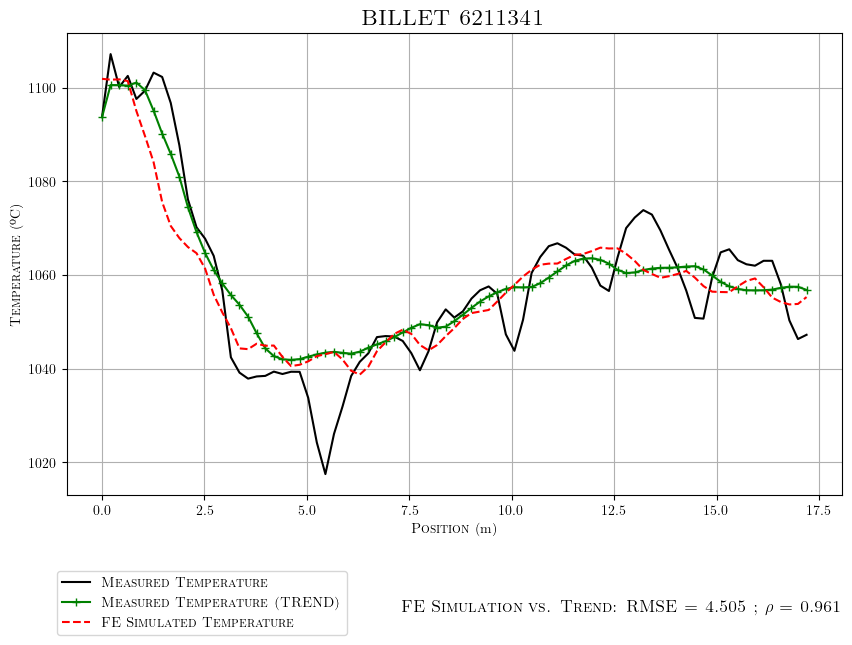

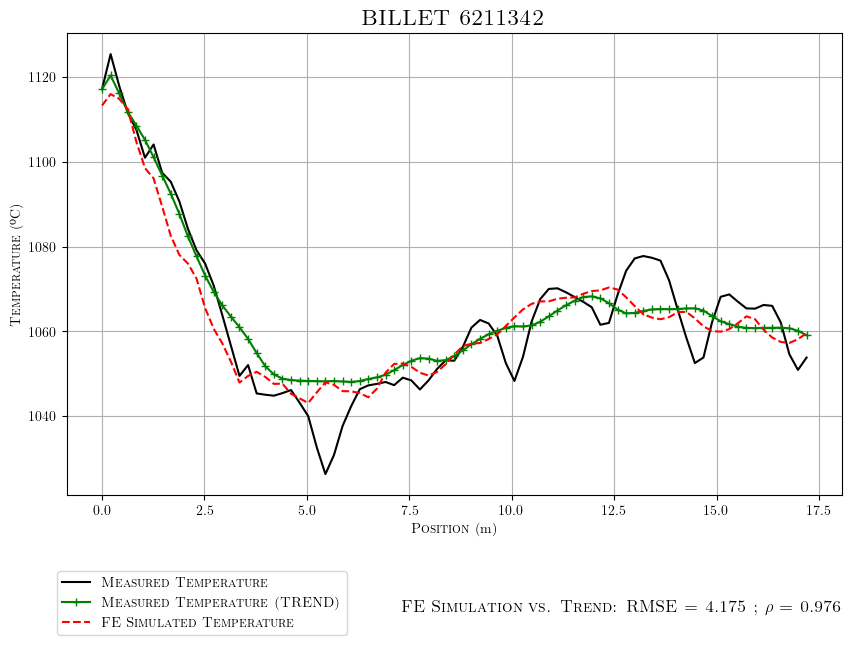

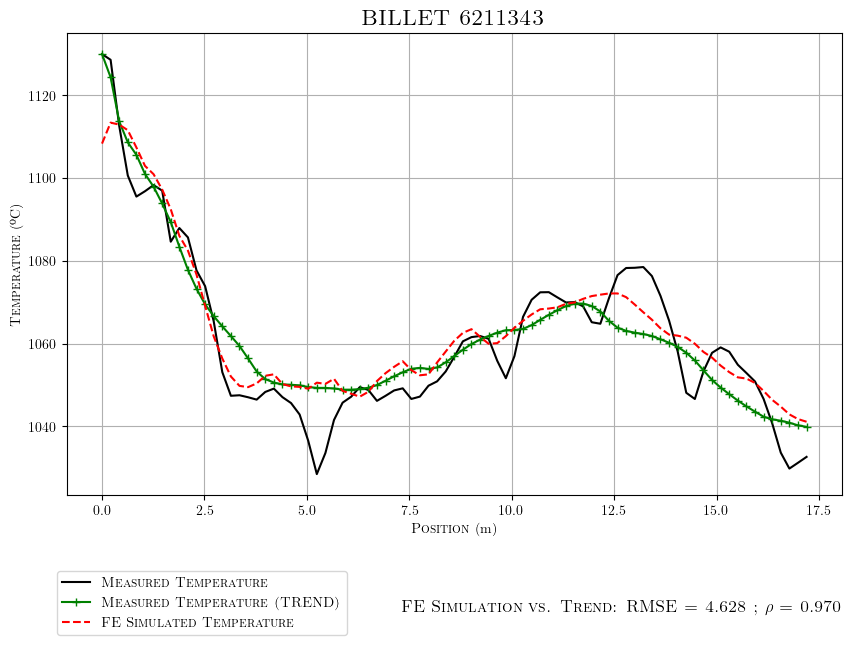

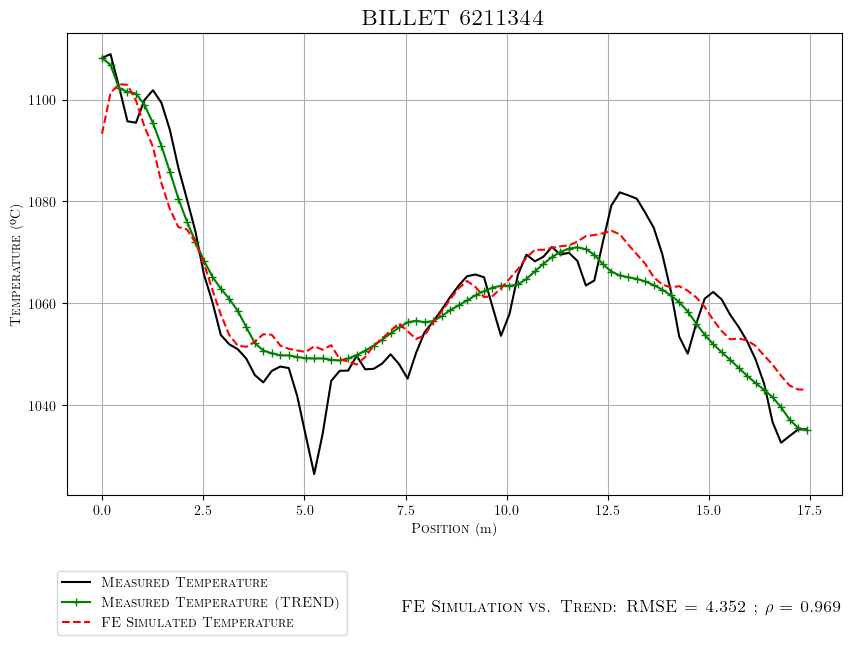

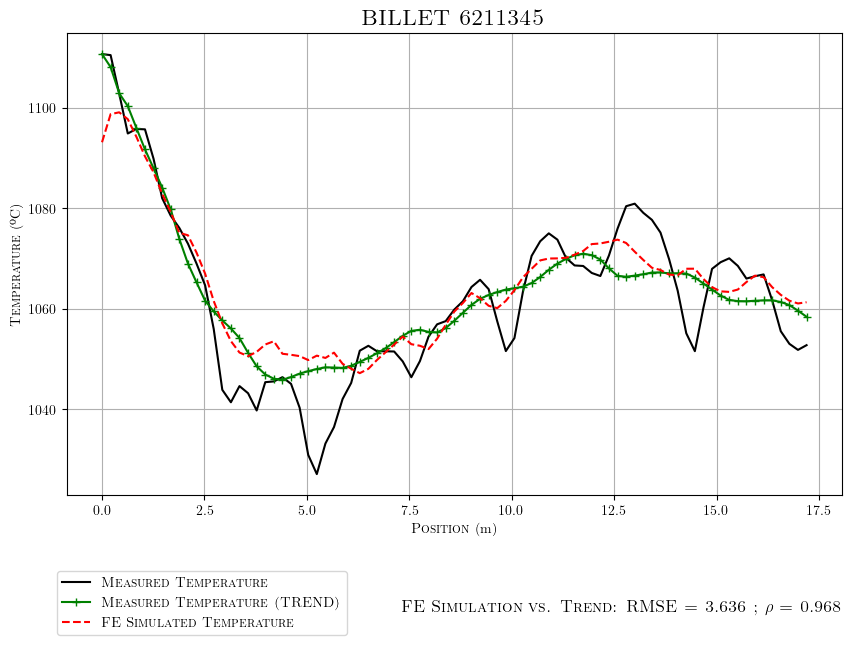

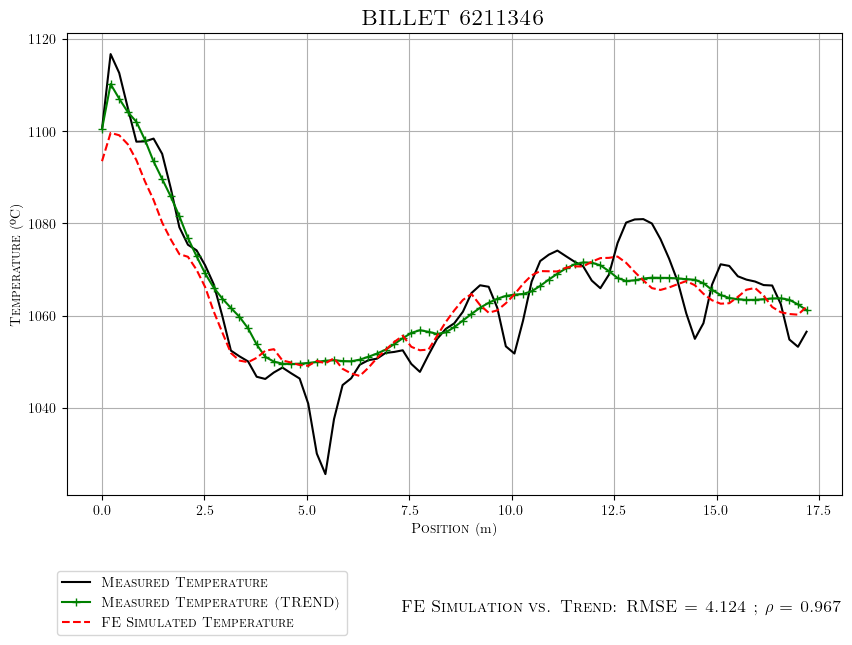

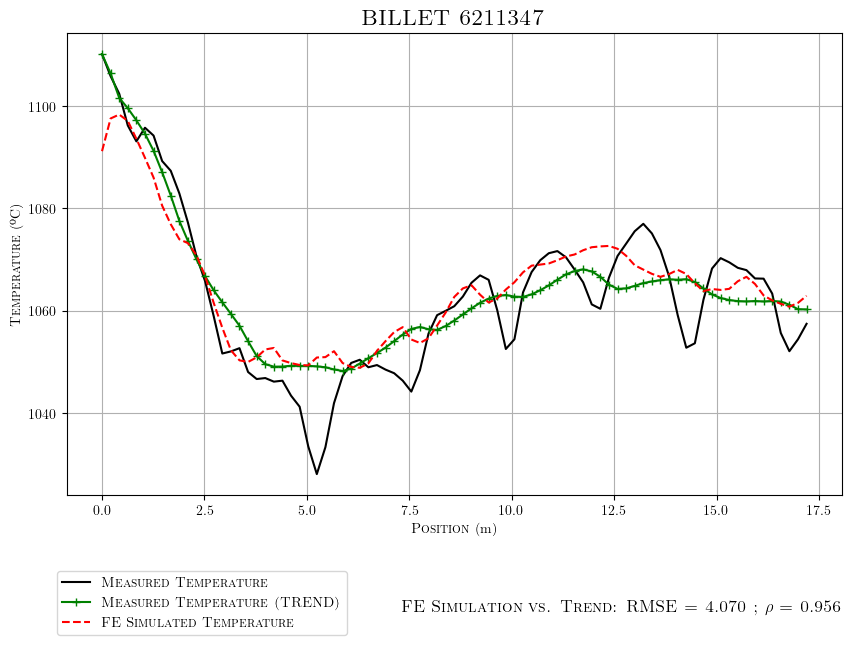

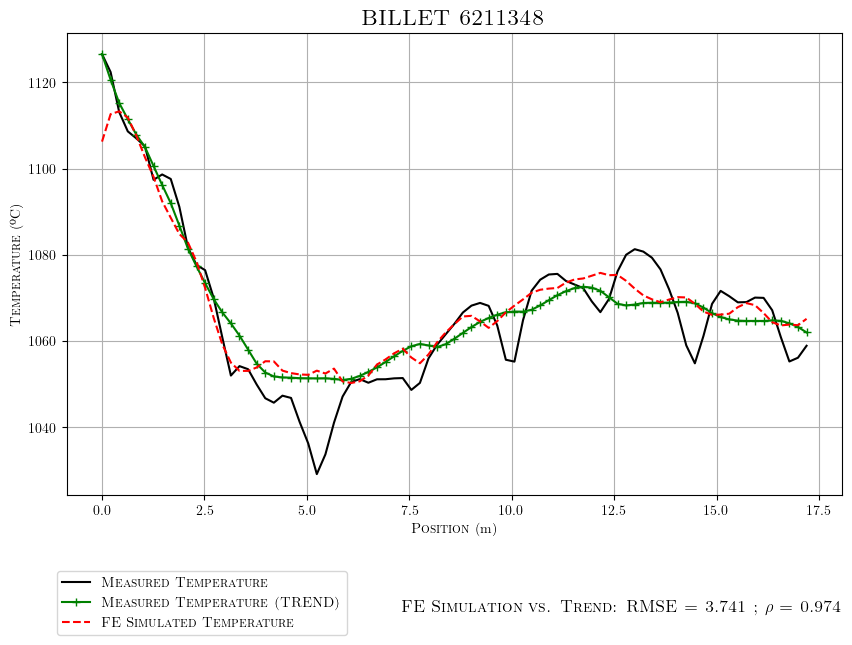

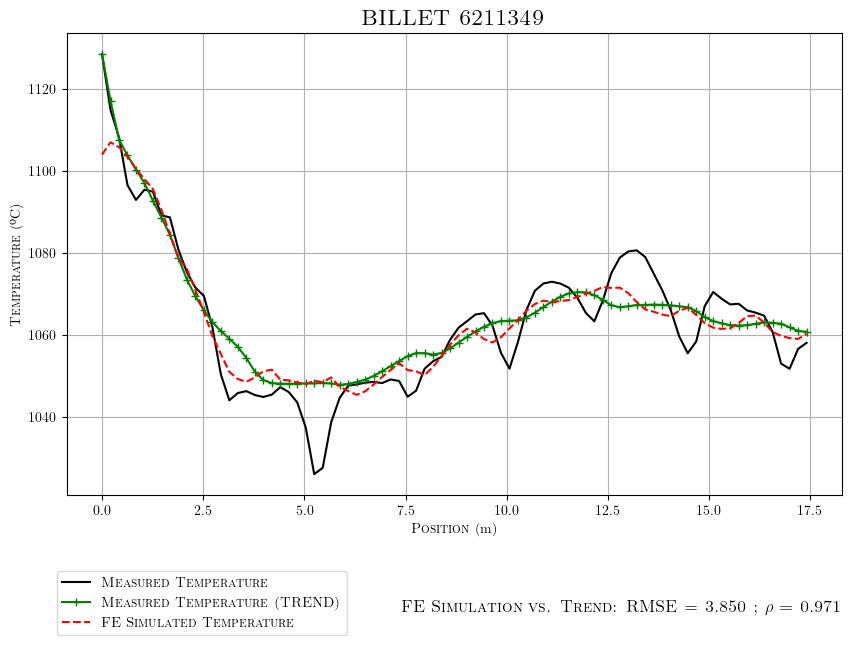

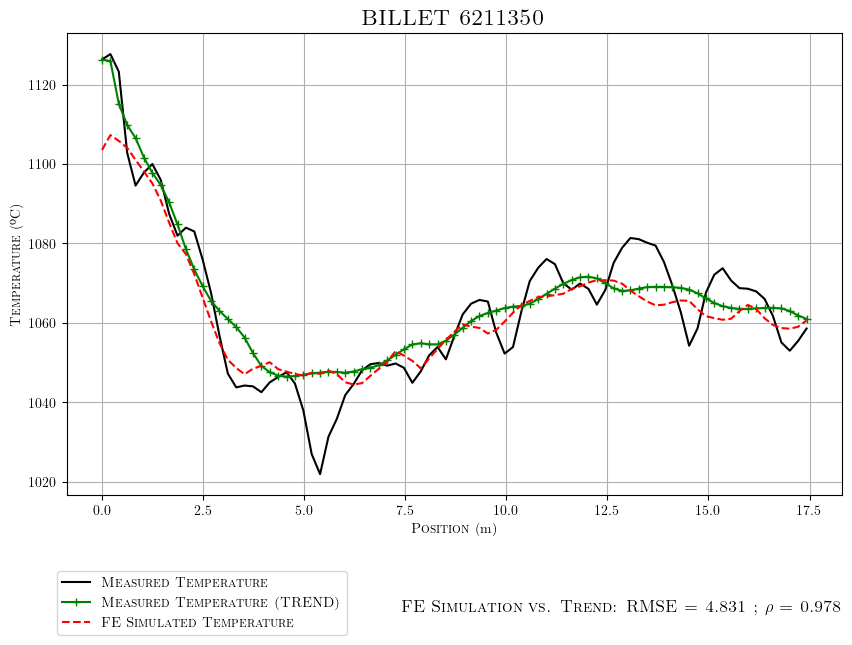

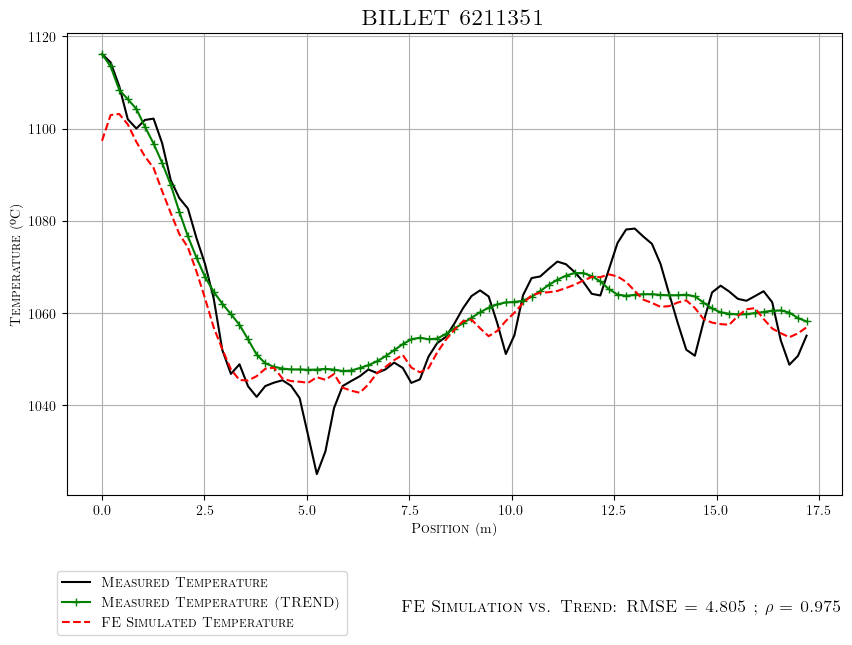

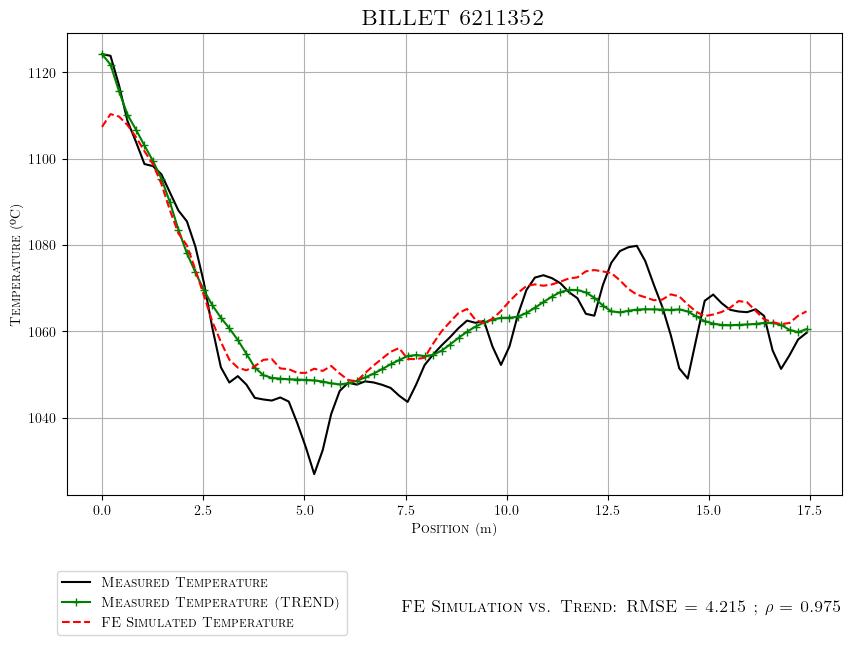

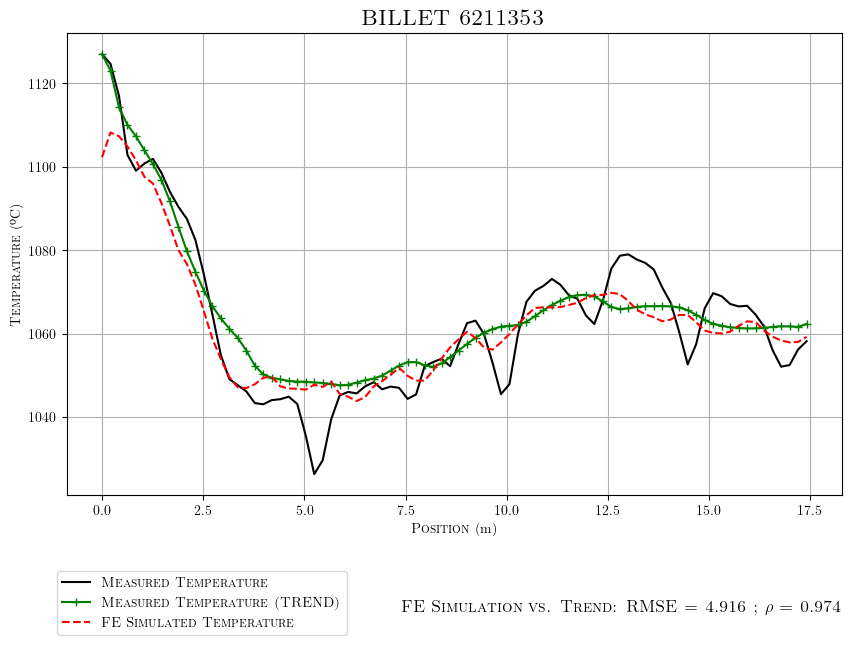

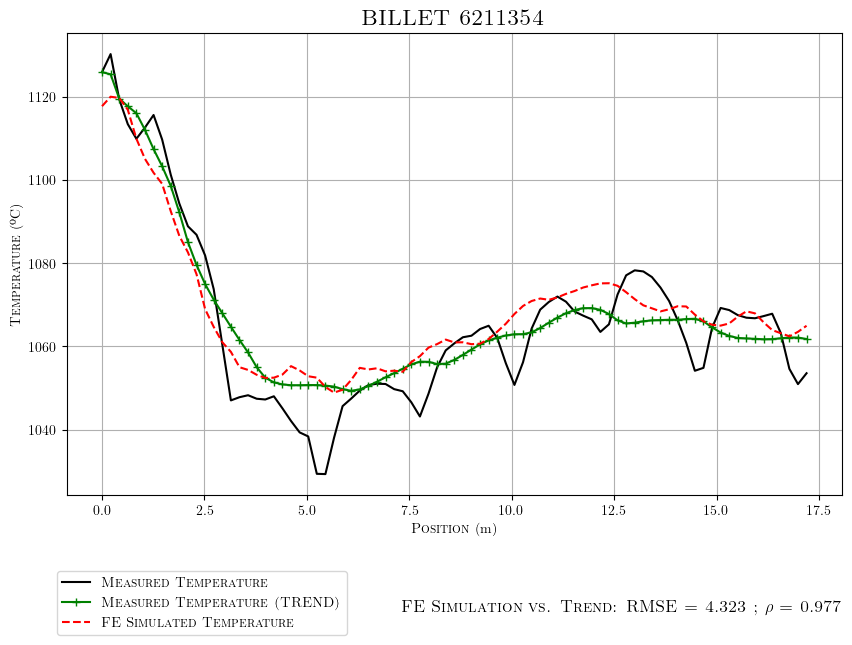

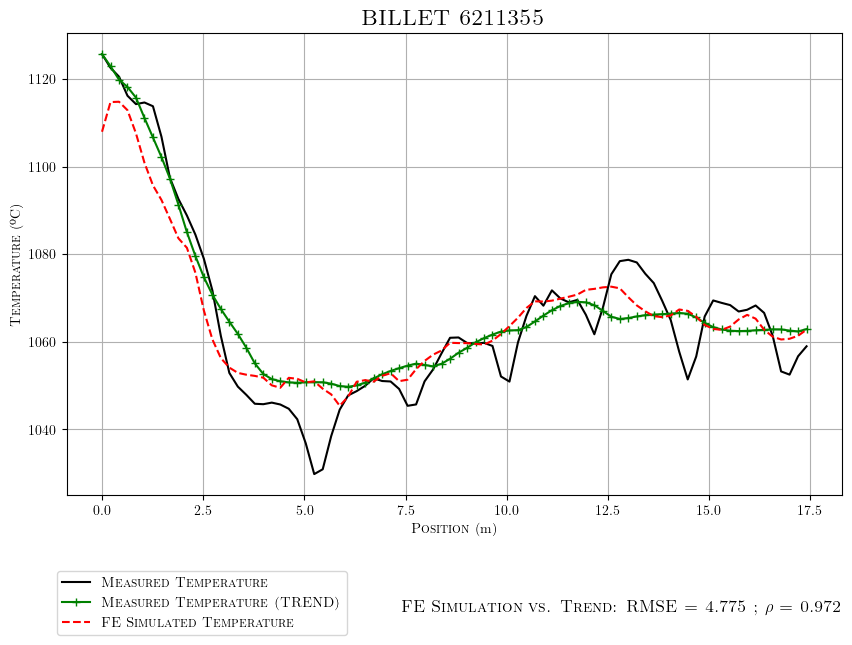

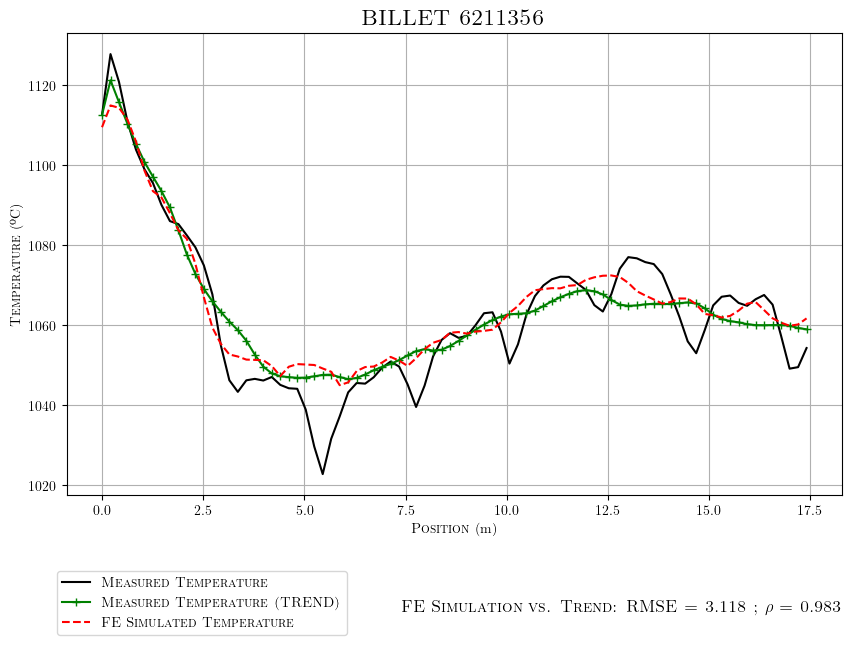

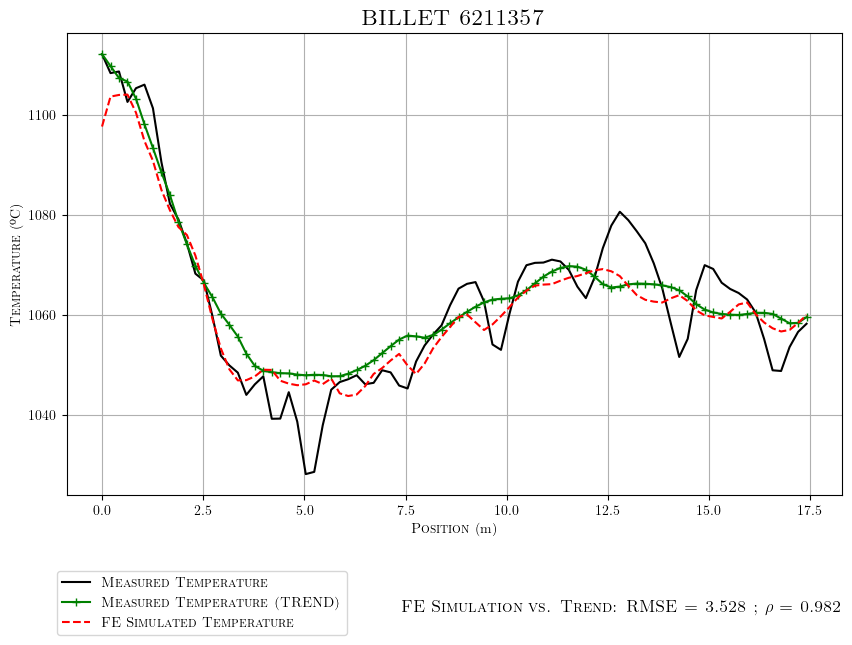

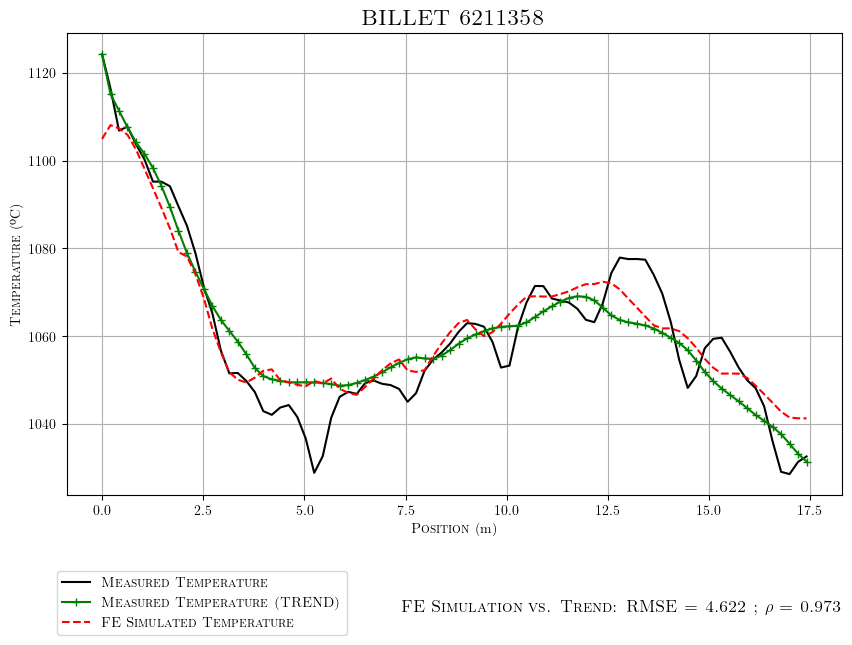

In [148]:
billet_record = pd.DataFrame(columns=['PALANQUILLA','CALIDAD','RMSE (Simul.vs.Original)', 'CORRELACION (Simul.vs.Original)', 'RMSE (Simul.vs.Tendencia)', 'CORRELACION (Simul.vs.Tendencia)'])

for billet in simul_billets[0:18]:
    metrics = compare_simulations_vs_original_data(int(billet))
    billet_record = pd.concat([billet_record, pd.DataFrame(data=metrics, columns = billet_record.columns)], ignore_index=True)

In [149]:
billet_record.to_csv('RMSE_corr_por_palanquilla_calibration.csv', index=False)

In [150]:
billet_record

,PALANQUILLA,CALIDAD,RMSE (Simul.vs.Original),CORRELACION (Simul.vs.Original),RMSE (Simul.vs.Tendencia),CORRELACION (Simul.vs.Tendencia)
0,6211341,resulfurado_Pb,8.698992,0.904838,4.505185,0.961211
1,6211342,resulfurado_Pb,7.102206,0.942437,4.174721,0.975889
2,6211343,resulfurado_Pb,7.212328,0.948262,4.627974,0.970463
3,6211344,resulfurado_Pb,7.554237,0.936359,4.351687,0.968947
4,6211345,resulfurado_Pb,7.504667,0.926795,3.635504,0.968375
5,6211346,resulfurado_Pb,7.382013,0.935940,4.124456,0.966630
6,6211347,resulfurado_Pb,7.164723,0.925988,4.069915,0.956170
7,6211348,resulfurado_Pb,7.113276,0.944390,3.741497,0.973991
8,6211349,resulfurado_Pb,6.787117,0.934461,3.850228,0.971105
9,6211350,resulfurado_Pb,8.267916,0.934022,4.831053,0.978323


Hago unos histogramas para ver el comportamiento en las palanquillas de calibrado...

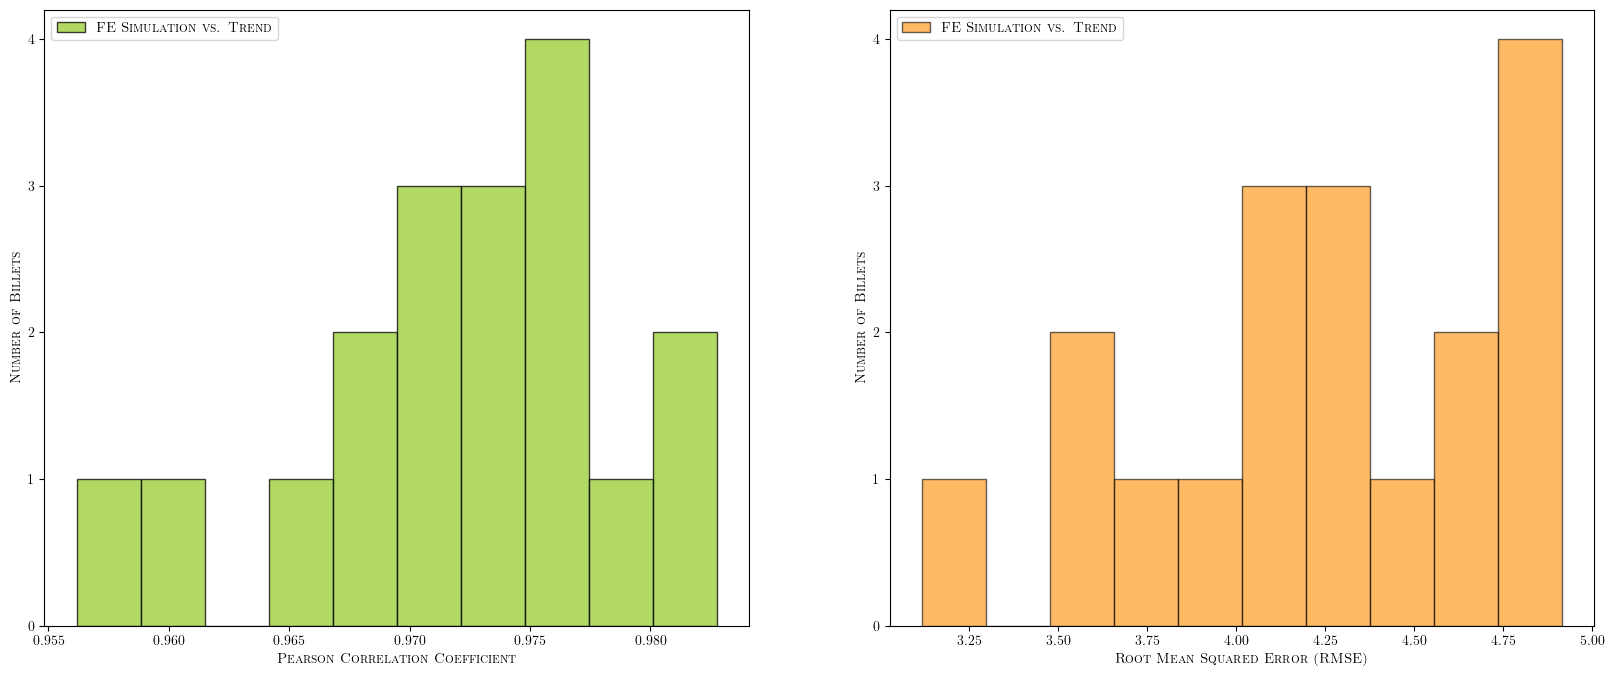

In [154]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))  # Adjust the values (20, 8) to your desired dimensions

# First subplot
ax1 = axes[0]
ax1.hist(billet_record["CORRELACION (Simul.vs.Tendencia)"][0:18], bins=10, alpha=0.75, label=r"\textsc{FE Simulation vs. Trend}", edgecolor="black", color="yellowgreen")
ax1.set_xlabel(r"\textsc{Pearson Correlation Coefficient}")
ax1.set_ylabel(r"\textsc{Number of Billets}")
ax1.legend()
ax1.set_yticks(range(int(ax1.get_ylim()[1]) + 1))

# Second subplot
ax2 = axes[1]
ax2.hist(billet_record["RMSE (Simul.vs.Tendencia)"][0:18], bins=10, alpha=0.6, label=r"\textsc{FE Simulation vs. Trend}", edgecolor="black", color="darkorange")
ax2.set_xlabel(r"\textsc{Root Mean Squared Error (RMSE)}")
ax2.set_ylabel(r"\textsc{Number of Billets}")
ax2.legend()
ax2.set_yticks(range(int(ax2.get_ylim()[1]) + 1))

plt.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots as needed
plt.savefig("comparative-plots/histograms_corr_rmse.png", dpi=600, bbox_inches="tight")
plt.show()